## <font color='emperal'/> **📘 📘 📘 Introduction**

Cellpose Model is very sensitive about **diameter** of cell. In order to achive high accuracy, we have to train Size Model which predicts diameter of every single cell then use that predicted diameter to predict mask.

In the scope of this notebook, Size Model is trained with Satorius dataset and additional LIVECell Shsy5y images proposed by the host.

📌 LIVECell Shsy5y data generator can be founded here: https://www.kaggle.com/code/luukhang/sartorius-livecell-shsy5y-data-gen

📌 Train Cellpose notebook can be founded here: **Update later**

📌 Inference Cellpose notebook can be founded here: https://www.kaggle.com/luukhang/sartorius-cellpose-inference

Cellpose link: https://github.com/MouseLand/cellpose

*Please upvote if this notebook is useful 👍 👍 👍*

## <font color='emperal'/> **Setting, import and prepare data**

In [1]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install opencv-python-headless==4.1.2.30
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf
!pip install -q pycocotools
!pip install -q fastremap
!pip install -q natsort

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 28.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.4.60
    Uninstalling opencv-python-headless-4.5.4.60:
      Successfully uninstalled opencv-python-headless-4.5.4.60


In [2]:
import sys
sys.path.append('../input/sartorius-instance-segmentation/cellpose/cellpose')

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys
import tifffile
import imageio
import glob
import shutil
from cellpose import models, io, plot, utils
import glob
import shutil
import imgaug.augmenters as iaa
import imgaug as ia
import time
import cv2
import torch

In [4]:
!mkdir './cellpose_dataset_train'
!mkdir './cellpose_dataset_val'
!mkdir './models'

In [5]:
# Original Image Dimensions
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

In [6]:
def rles_to_mask(encs, shape=SHAPE):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

In [7]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

from tqdm.auto import tqdm

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [
        compute_iou(rles_to_mask(truth,shape), rles_to_mask(pred,shape)) 
            for truth, pred in tqdm(zip(truths, preds))
    ]
    
    if verbose:
        print(ious[0].shape)
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
for f in glob.glob('../input/sartorius-cellpose-dataset/train/*.tif'):
    if 'flows' not in f:
        shutil.copy(f, os.path.join('./cellpose_dataset_train', f.split('/')[-1]))

In [9]:
for f in glob.glob('../input/sartorius-cellpose-dataset/val/*.tif'):
    if 'flows' not in f:
        shutil.copy(f, os.path.join('./cellpose_dataset_val', f.split('/')[-1]))

In [10]:
train_folder = './cellpose_dataset_train'
test_folder = './cellpose_dataset_val'

In [11]:
!ls {train_folder} | wc -l
!ls {test_folder} | wc -l

970
242


In [12]:
train_img_files = np.sort(glob.glob(os.path.join('cellpose_dataset_train', '*img.tif')))
train_mask_files = np.sort(glob.glob(os.path.join('cellpose_dataset_train', '*masks.tif')))

val_img_files = np.sort(glob.glob(os.path.join('cellpose_dataset_val', '*img.tif')))
val_mask_files = np.sort(glob.glob(os.path.join('cellpose_dataset_val', "*masks.tif")))

assert (len(train_img_files ) == len(train_mask_files)) and (len(val_img_files) == len(val_mask_files))

train_imgs = [tifffile.imread(img_file) for img_file in tqdm(train_img_files)]
train_masks = [tifffile.imread(flows_file) for flows_file in tqdm(train_mask_files)]

val_imgs = [tifffile.imread(img_file) for img_file in tqdm(val_img_files)]
val_masks = [tifffile.imread(flows_file) for flows_file in tqdm(val_mask_files)]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

In [13]:
print(len(train_imgs))
print(len(val_imgs))

485
121


## <font color='emperal'/> **Init and train size model**

In [14]:
model_path = '../input/sartorius-weight/cellpose_250622_concat_epoch_500'

In [15]:
model_path = shutil.copy(model_path, './models')

In [16]:
cp_model = models.CellposeModel(gpu=True, pretrained_model='./models/cellpose_250622_concat_epoch_500', nchan=2)
sz_model = models.SizeModel(cp_model=cp_model)

In [17]:
from cellpose.io import logger_setup
logger, log_file = logger_setup()

start_time = time.time()

params, epochs, train_corr_vls, val_corr_vls = sz_model.train(train_imgs, train_masks, val_imgs, val_masks, 
                        channels=[0, 0], n_epochs=200, learning_rate=0.01)

end_time = time.time()

creating new log file


In [18]:
training_time = (end_time - start_time) / 60

print('Train {} epochs took {} minutes'.format(200, training_time))

Train 200 epochs took 72.26106625795364 minutes


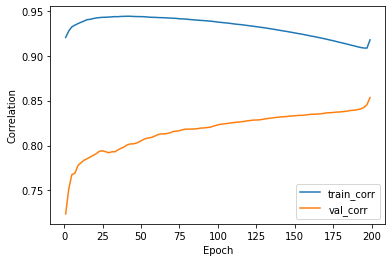

In [19]:
fig = plt.figure(figsize=(6, 4))

plt.plot(epochs, train_corr_vls)
plt.plot(epochs, val_corr_vls)
plt.legend(['train_corr', 'val_corr'])

plt.xlabel('Epoch')
plt.ylabel('Correlation')

plt.show()

In [20]:
print('Train corr', train_corr_vls[-1])
print('Val corr', val_corr_vls[-1])

Train corr 0.9176829662300355
Val corr 0.8534106870790333


In [21]:
os.listdir('./models')

['cellpose_250622_concat_epoch_500_size.npy',
 'cellpose_250622_concat_epoch_500']

<a href='./models/cellpose_250622_concat_epoch_500_size.npy'/> Download

## <font color='emperal'/> **References**

https://www.kaggle.com/code/aishikai/scs-cellpose-train